# OWA Wake Modelling Challenge 

## Introduction
This script summarizes the results of the [OWA Wake Modeling Challenge](https://www.carbontrust.com/media/677495/owa-wake-modelling-challenge_final-feb27.pdf).

## Load libraries

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import warnings

from src.WindConditions import *
from src.BinAvrg import *  
from scipy import interpolate
from IPython.display import Markdown, display
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

## Sites

In [3]:
n_sites = 5 # number of submited simulations + 1 (ensemble)
sites = pd.DataFrame(columns = ['Name','ID','Data Provider','LON', 'LAT','From','To','Ptot(MW)',
                                'Nt','Turbine Type','P(MW)','D(m)','zhub(m)'],
                     index = np.arange(0,n_sites,1))

sites.loc[0]  = ['Anholt'          , 'anh', 'Ørsted'     , 11.2   , 56.6   , '1-Jan-2013', '30-Jun-2015', 399.6, 111, 'SWT-3.6-120'    , 3.6, 120., 82.]
sites.loc[1]  = ['Dudgeon'         , 'dud', 'Equinor'    , 1.3816 , 53.2585, '1-Dec-2017', '30-Nov-2018', 402. , 67 , 'SWT-6.0-154'    , 6. , 154., 110.]
sites.loc[2]  = ['Rodsand2'       , 'rod', 'EON'        , 11.4610, 54.573 , '1-Feb-2013', '30-Jun-2014', 207. , 90 , 'SWT-2.3-93'     , 2.3, 82.4, 68.5]
sites.loc[3]  = ['WestermostRough', 'wmr', 'Ørsted'     , 0.1512 , 53.796 , '1-Jan-2016', '31-Dec-2017', 210. , 35 , 'SWT-6.0-154'    , 6. , 154., 106.]
sites.loc[4]  = ['Ormonde'         , 'orm', 'Vattenfall' , -3.444 , 54.0873, '1-Jan-2012', '28-Feb-2019', 150. , 30 , 'Repower-5.0-126', 5. , 126., 100.]

sites.style.set_properties(**{'text-align': 'center'})

,Name,ID,Data Provider,LON,LAT,From,To,Ptot(MW),Nt,Turbine Type,P(MW),D(m),zhub(m)
0,Anholt,anh,Ørsted,11.2,56.6,1-Jan-2013,30-Jun-2015,399.6,111,SWT-3.6-120,3.6,120,82
1,Dudgeon,dud,Equinor,1.3816,53.2585,1-Dec-2017,30-Nov-2018,402,67,SWT-6.0-154,6,154,110
2,Rodsand2,rod,EON,11.461,54.573,1-Feb-2013,30-Jun-2014,207,90,SWT-2.3-93,2.3,82.4,68.5
3,WestermostRough,wmr,Ørsted,0.1512,53.796,1-Jan-2016,31-Dec-2017,210,35,SWT-6.0-154,6,154,106
4,Ormonde,orm,Vattenfall,-3.444,54.0873,1-Jan-2012,28-Feb-2019,150,30,Repower-5.0-126,5,126,100


## Load metrics for all the sites

In [4]:
bias = dict.fromkeys(sites['ID'])
mae = dict.fromkeys(sites['ID'])
for i in range(n_sites):
    bias[sites['ID'][i]] = pd.read_csv('./' + sites["Name"][i] + '/results/' + sites["ID"][i]+ '_bias.csv',index_col = 0)
    mae[sites['ID'][i]] = pd.read_csv('./' + sites["Name"][i] + '/results/' + sites["ID"][i]+ '_mae.csv',index_col = 0)    

## Results

In [5]:
# Select which simulations will be included in the plots for each site
plotresults = dict.fromkeys(sites['ID'])

# Only participants that submitted results for all the sites 
# Excluded simulations with ctrl-input when farm-farm effects are present
plotresults['anh'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plotresults['dud'] = [0,1,2,3,4,7,9,10,11,12,13,14,15,16]
plotresults['rod'] = [0,1,2,3,4,6,7,9,10,11,12,13,14,15,16,17,18,19]
plotresults['wmr'] = [0,1,2,4,6,8,9,10,11,12,13,14,15]
plotresults['orm'] = [0,1,2,3,4,6,8,9,10,11,12,13,14,15]

# Common set of simulations for all the sites 
plotresults['anh'] = [0,1,2,3,4,5 ,6 ,8 ,11,12,13,14,15]
plotresults['dud'] = [0,1,2,4,7,9 ,10,11,12,13,14,15,16]
plotresults['rod'] = [0,1,2,3,7,10,12,14,15,16,17,18,19]
plotresults['wmr'] = [0,1,2,4,6,8 ,9 ,10,11,12,13,14,15]
plotresults['orm'] = [0,1,2,4,6,8 ,9 ,10,11,12,13,14,15]

# Create a single dataframe with all the results 
for site in sites['ID']:
    bias[site]['site'] = site  # add a column with the site ID to be able to filter the results by site 
    mae[site]['site'] = site  # add a column with the site ID to be able to filter the results by site 

bias_df = pd.concat([bias[site].iloc[plotresults[site]] for site in sites['ID']], axis = 0)
mae_df = pd.concat([mae[site].iloc[plotresults[site]] for site in sites['ID']], axis = 0)

Text(0.5, 1.0, 'MAE = |$\\eta_{bench}-\\eta_{sim}$|')

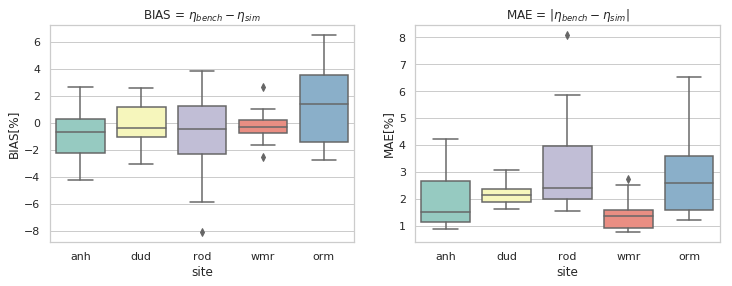

In [6]:
sns.set(style="whitegrid", palette="Set3")

# Overall results
plt.figure(figsize=(12, 4))    
ax1 = plt.subplot(1, 2, 1)
ax1 = sns.boxplot(x='site', y='BIAS[%]', data = bias_df)
#ax1 = sns.swarmplot(x='site', y='BIAS[%]', data = bias_df, color=".25")
ax1.set_title('BIAS = $\eta_{bench}-\eta_{sim}$')
ax2 = plt.subplot(1, 2, 2)
ax2 = sns.boxplot(x='site', y='MAE[%]', data = mae_df)
#ax2 = sns.swarmplot(x='site', y='MAE[%]', data = mae_df, color=".25")
ax2.set_title('MAE = |$\eta_{bench}-\eta_{sim}$|')

Text(0.5, 1.0, 'MAE = |$\\eta_{bench}-\\eta_{sim}$|')

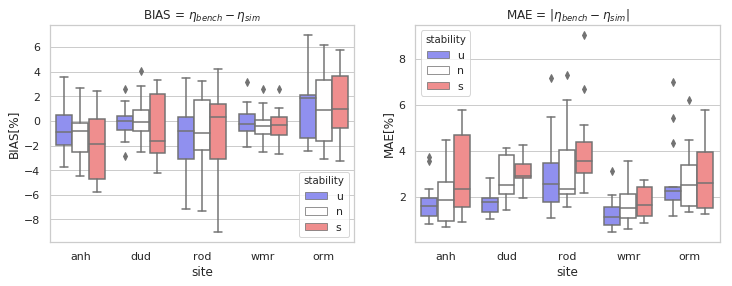

In [7]:
# Results by stability
cols = bias_df.columns.values
u = np.arange(10,46,3) # index to unstable 
n = np.arange(11,46,3) # index to neutral
s = np.arange(12,46,3) # index to stable

bias_u = bias_df[['ID', 'site']].copy()
bias_u['BIAS[%]'] = bias_df[cols[u]].mean(axis = 1)
bias_u['stability'] = 'u'
bias_n = bias_df[['ID', 'site']].copy()
bias_n['BIAS[%]'] = bias_df[cols[n]].mean(axis = 1)
bias_n['stability'] = 'n'
bias_s = bias_df[['ID', 'site']].copy()
bias_s['BIAS[%]'] = bias_df[cols[s]].mean(axis = 1)
bias_s['stability'] = 's'
bias_stab = pd.concat([bias_u,bias_n,bias_s], axis = 0)

mae_u = mae_df[['ID', 'site']].copy()
mae_u['MAE[%]'] = mae_df[cols[u]].mean(axis = 1)
mae_u['stability'] = 'u'
mae_n = mae_df[['ID', 'site']].copy()
mae_n['MAE[%]'] = mae_df[cols[n]].mean(axis = 1)
mae_n['stability'] = 'n'
mae_s = mae_df[['ID', 'site']].copy()
mae_s['MAE[%]'] = mae_df[cols[s]].mean(axis = 1)
mae_s['stability'] = 's'
mae_stab = pd.concat([mae_u,mae_n,mae_s], axis = 0)

# Overall results
plt.figure(figsize=(12, 4))    
ax1 = plt.subplot(1, 2, 1)
ax1 = sns.boxplot(x='site', y='BIAS[%]', hue = 'stability', data = bias_stab, palette = 'bwr')
ax1.set_title('BIAS = $\eta_{bench}-\eta_{sim}$')
ax2 = plt.subplot(1, 2, 2)
ax2 = sns.boxplot(x='site', y='MAE[%]', hue = 'stability', data = mae_stab, palette = 'bwr')
ax2.set_title('MAE = |$\eta_{bench}-\eta_{sim}$|')